In [1]:
import numpy as np
import pandas as pd
import datetime
import gc

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

/Users/narimatsu_n/.pyenv/versions/3.5.0/lib/python3.5/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
df_train = pd.read_csv("../input/20181216_train.csv")
df_test= pd.read_csv("../input/20181216_test.csv")

In [3]:
def merge_new_feature(path):
    df_new_feature = pd.read_csv(path)
    
    df_tr = pd.merge(df_train, df_new_feature, on="card_id", how="left")
    df_te = pd.merge(df_test, df_new_feature, on="card_id", how="left")
    
    return df_tr, df_te

In [4]:
df_train, df_test = merge_new_feature("../input/merchants_nmf.csv")
print(df_train.shape)
df_train, df_test = merge_new_feature("../input/new_merchants_nmf.csv")
print(df_train.shape)
df_train, df_test = merge_new_feature("../input/prosperity_merchants_latest.csv")
print(df_train.shape)
df_train, df_test = merge_new_feature("../input/merchants_numerical_features.csv")
print(df_train.shape)
df_train, df_test = merge_new_feature("../input/merchants_item_scale_feature.csv")
print(df_train.shape)
df_train, df_test = merge_new_feature("../input/purchase_pattern.csv")
print(df_train.shape)
df_train, df_test = merge_new_feature("../input/purchase_pettern_nmf.csv")
print(df_train.shape)
df_train, df_test = merge_new_feature("../input/purchase_amount_pettern_nmf.csv")
print(df_train.shape)

(201917, 122)
(201917, 142)
(201917, 182)
(201917, 196)
(201917, 228)
(201917, 237)
(201917, 247)
(201917, 257)


In [5]:
df_train["Null_count"] = df_train.isnull().sum(axis=1)
df_test["Null_count"] = df_test.isnull().sum(axis=1)

In [6]:
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','second_active_date','diff_first_and_second','target','outliers']]
target = df_train['target']
target_outlier = df_train["outliers"]

In [7]:
max_each_col = np.max(df_train[df_train_columns].values, axis=0)

for i, max_ in enumerate(max_each_col):
    if max_ >= 1e+7:
        df_train[df_train_columns[i]] = 1/(1+np.exp(-1*df_train[df_train_columns[i]].values))
        df_test[df_train_columns[i]] = 1/(1+np.exp(-1*df_test[df_train_columns[i]].values))

In [8]:
#original
param = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'regression',
    'max_depth': -1,
    "max_bin": 256,  # なし
    'learning_rate': 0.004,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.73832	valid_1's rmse: 3.77481
[200]	training's rmse: 3.66948	valid_1's rmse: 3.73319
[300]	training's rmse: 3.62162	valid_1's rmse: 3.70972
[400]	training's rmse: 3.58507	valid_1's rmse: 3.69585
[500]	training's rmse: 3.55573	valid_1's rmse: 3.68486
[600]	training's rmse: 3.531	valid_1's rmse: 3.67694
[700]	training's rmse: 3.51038	valid_1's rmse: 3.67182
[800]	training's rmse: 3.49233	valid_1's rmse: 3.6681
[900]	training's rmse: 3.47613	valid_1's rmse: 3.66443
[1000]	training's rmse: 3.46075	valid_1's rmse: 3.66184
[1100]	training's rmse: 3.44671	valid_1's rmse: 3.6594
[1200]	training's rmse: 3.43382	valid_1's rmse: 3.65733
[1300]	training's rmse: 3.42139	valid_1's rmse: 3.65554
[1400]	training's rmse: 3.40917	valid_1's rmse: 3.65411
[1500]	training's rmse: 3.39756	valid_1's rmse: 3.65238
[1600]	training's rmse: 3.38652	valid_1's rmse: 3.65124
[1700]	training's rmse: 3.37596	valid_1's rmse:

[2300]	training's rmse: 3.30804	valid_1's rmse: 3.66611
[2400]	training's rmse: 3.29936	valid_1's rmse: 3.66587
[2500]	training's rmse: 3.29089	valid_1's rmse: 3.6656
[2600]	training's rmse: 3.28241	valid_1's rmse: 3.66554
[2700]	training's rmse: 3.27443	valid_1's rmse: 3.66553
[2800]	training's rmse: 3.2659	valid_1's rmse: 3.66543
[2900]	training's rmse: 3.25843	valid_1's rmse: 3.66529
[3000]	training's rmse: 3.25095	valid_1's rmse: 3.66515
[3100]	training's rmse: 3.24329	valid_1's rmse: 3.66517
[3200]	training's rmse: 3.23583	valid_1's rmse: 3.66515
[3300]	training's rmse: 3.22904	valid_1's rmse: 3.66504
[3400]	training's rmse: 3.22203	valid_1's rmse: 3.66493
[3500]	training's rmse: 3.21464	valid_1's rmse: 3.665
[3600]	training's rmse: 3.20774	valid_1's rmse: 3.66498
[3700]	training's rmse: 3.20127	valid_1's rmse: 3.66497
[3800]	training's rmse: 3.19403	valid_1's rmse: 3.66474
[3900]	training's rmse: 3.18752	valid_1's rmse: 3.66475
[4000]	training's rmse: 3.18128	valid_1's rmse: 3.66

3.6455783997778

In [9]:
# score:  3.6467757129353053

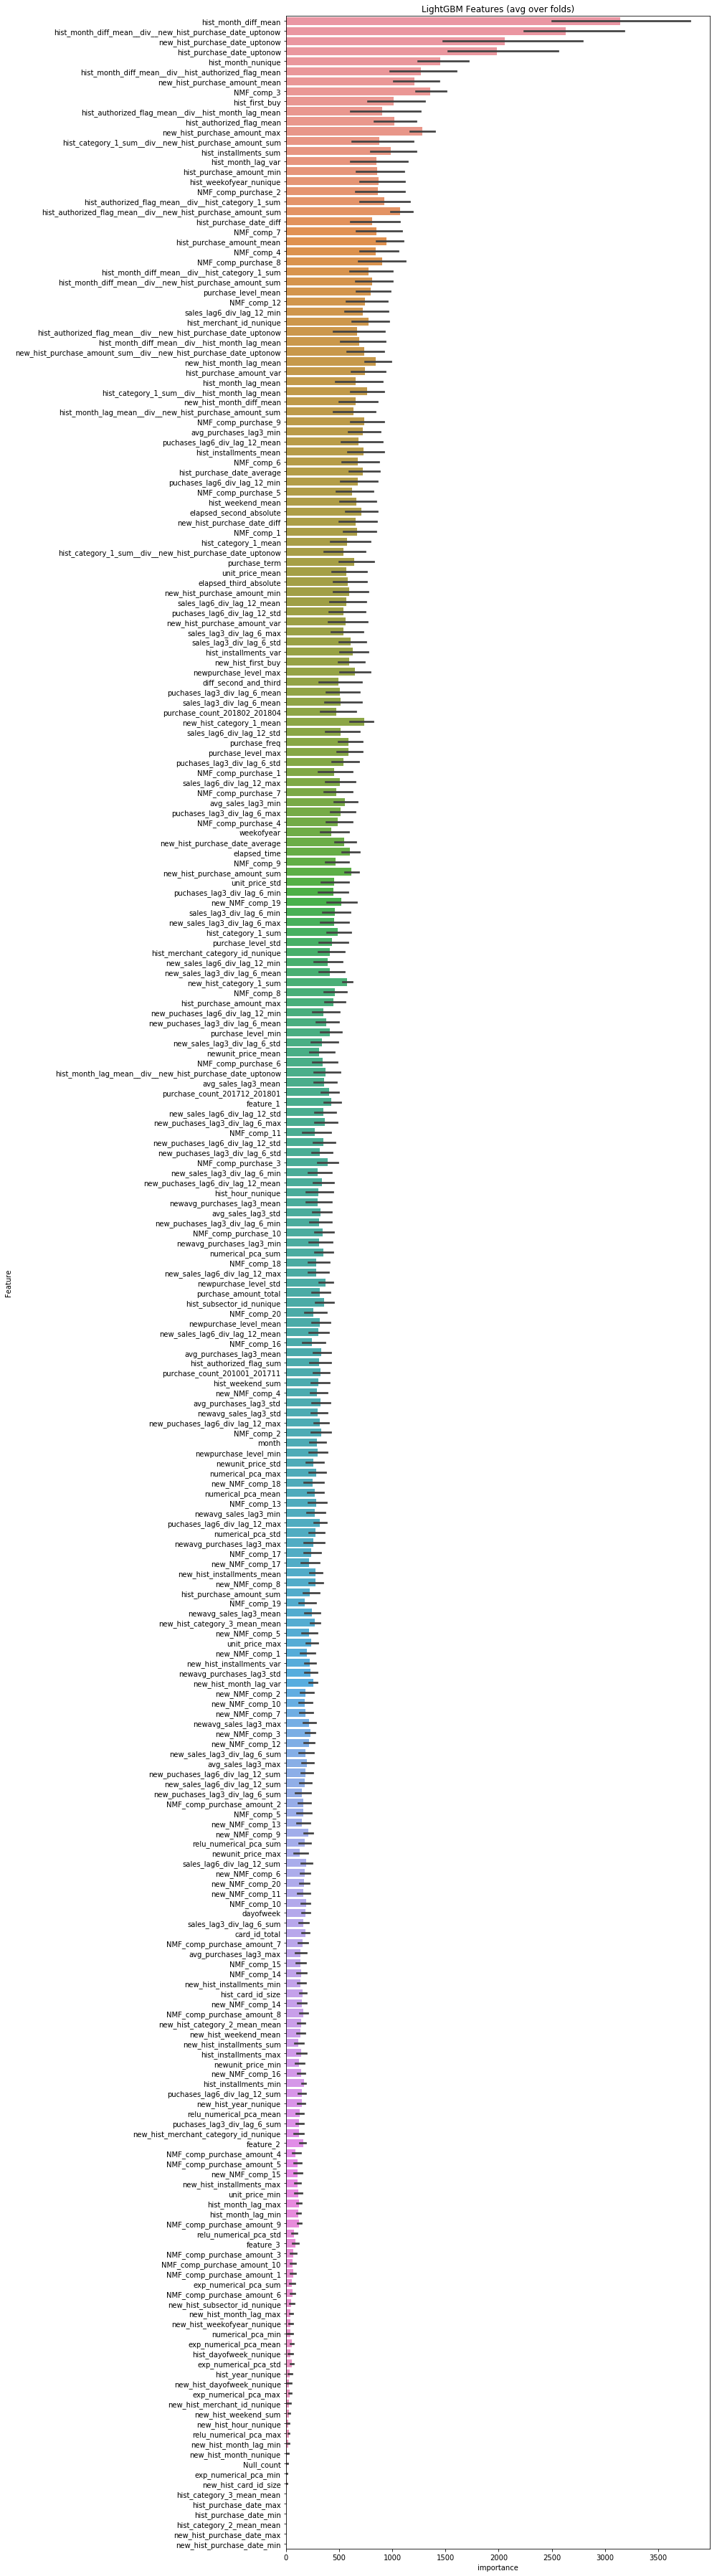

In [10]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')

In [11]:
df_train2 = df_train[df_train.target >= -20].reset_index(drop=True)
target2 = df_train2["target"]

#original
param2 = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'regression',
    'max_depth': -1,
    'learning_rate': 0.01,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train2))
predictions2 = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train2,df_train2['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train2.iloc[trn_idx][df_train_columns], label=target2.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train2.iloc[val_idx][df_train_columns], label=target2.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param2, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train2.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions2 += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target2))

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 1.60724	valid_1's rmse: 1.60695
[200]	training's rmse: 1.57575	valid_1's rmse: 1.57845
[300]	training's rmse: 1.56045	valid_1's rmse: 1.56721
[400]	training's rmse: 1.54991	valid_1's rmse: 1.56149
[500]	training's rmse: 1.54158	valid_1's rmse: 1.55784
[600]	training's rmse: 1.5344	valid_1's rmse: 1.55563
[700]	training's rmse: 1.52801	valid_1's rmse: 1.55413
[800]	training's rmse: 1.52233	valid_1's rmse: 1.55319
[900]	training's rmse: 1.51713	valid_1's rmse: 1.55265
[1000]	training's rmse: 1.51216	valid_1's rmse: 1.55222
[1100]	training's rmse: 1.50748	valid_1's rmse: 1.55188
[1200]	training's rmse: 1.50303	valid_1's rmse: 1.55169
[1300]	training's rmse: 1.49867	valid_1's rmse: 1.55146
[1400]	training's rmse: 1.49439	valid_1's rmse: 1.55139
[1500]	training's rmse: 1.49021	valid_1's rmse: 1.55132
[1600]	training's rmse: 1.48605	valid_1's rmse: 1.55118
[1700]	training's rmse: 1.48201	valid_1's rm

[900]	training's rmse: 1.51148	valid_1's rmse: 1.57959
[1000]	training's rmse: 1.50655	valid_1's rmse: 1.57917
[1100]	training's rmse: 1.50186	valid_1's rmse: 1.57882
[1200]	training's rmse: 1.49725	valid_1's rmse: 1.57865
[1300]	training's rmse: 1.49287	valid_1's rmse: 1.57844
[1400]	training's rmse: 1.48861	valid_1's rmse: 1.57835
[1500]	training's rmse: 1.48444	valid_1's rmse: 1.57821
[1600]	training's rmse: 1.48034	valid_1's rmse: 1.57813
[1700]	training's rmse: 1.47635	valid_1's rmse: 1.578
[1800]	training's rmse: 1.47235	valid_1's rmse: 1.5779
[1900]	training's rmse: 1.4684	valid_1's rmse: 1.5778
[2000]	training's rmse: 1.46458	valid_1's rmse: 1.57768
[2100]	training's rmse: 1.46085	valid_1's rmse: 1.57775
[2200]	training's rmse: 1.45706	valid_1's rmse: 1.57759
[2300]	training's rmse: 1.45333	valid_1's rmse: 1.57753
[2400]	training's rmse: 1.44964	valid_1's rmse: 1.57746
[2500]	training's rmse: 1.44591	valid_1's rmse: 1.57748
[2600]	training's rmse: 1.44226	valid_1's rmse: 1.5775

1.5565972841082747

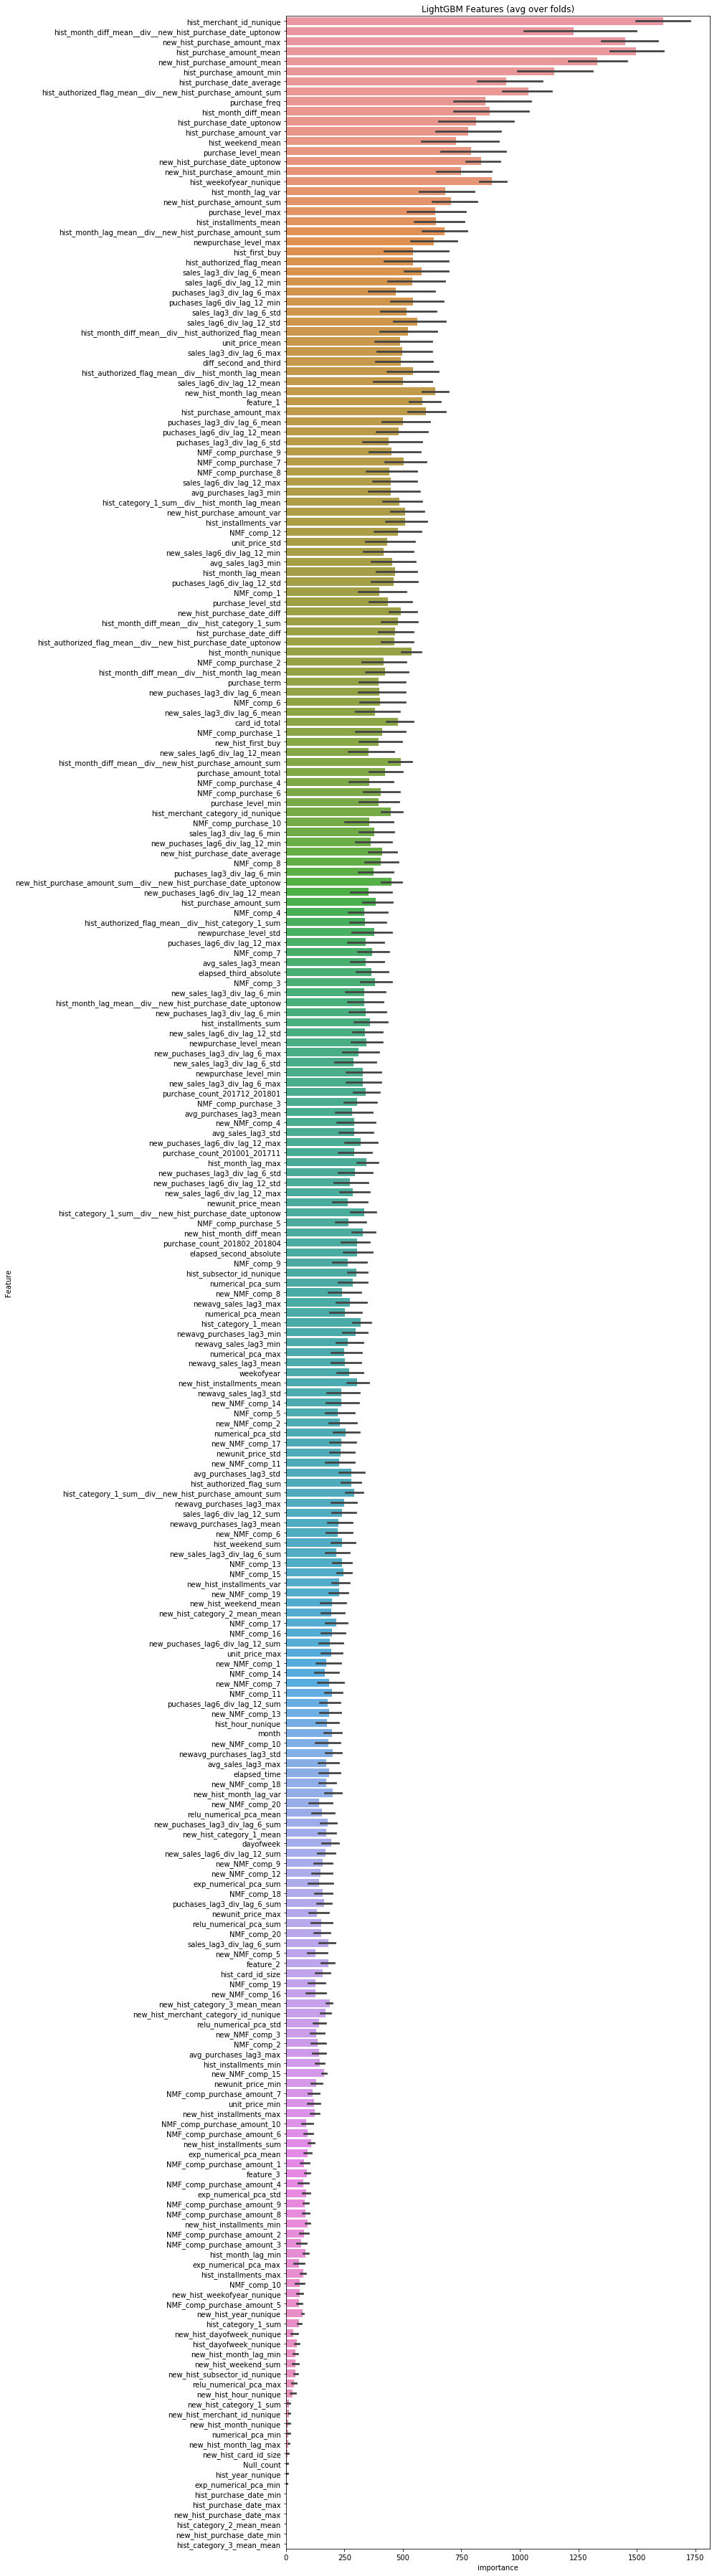

In [12]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')

In [13]:
df_prediction = pd.DataFrame({"prediction1":predictions, "prediction2":predictions2})
df_prediction

,prediction1,prediction2
0,-1.848485,-0.508580
1,-0.254338,-0.284874
2,-0.981361,-0.440727
3,-0.099155,-0.087757
4,-1.501619,-1.813502
5,0.046443,0.605448
6,0.054393,0.144328
7,0.501794,0.868373
8,-0.573810,-0.624707
9,-0.949550,-0.151067


In [14]:
predictions3 = np.zeros(df_prediction.shape[0])
for i, r in df_prediction.iterrows():
    if r[0] < 0 :
        predictions3[i] = r[0]
    else:
        predictions3[i] = r[1]
df_prediction["prediction3"] = predictions3

In [15]:
df_prediction

,prediction1,prediction2,prediction3
0,-1.848485,-0.508580,-1.848485
1,-0.254338,-0.284874,-0.254338
2,-0.981361,-0.440727,-0.981361
3,-0.099155,-0.087757,-0.099155
4,-1.501619,-1.813502,-1.501619
5,0.046443,0.605448,0.605448
6,0.054393,0.144328,0.144328
7,0.501794,0.868373,0.868373
8,-0.573810,-0.624707,-0.573810
9,-0.949550,-0.151067,-0.949550


In [16]:
final_predictions = df_prediction.prediction3.values

In [17]:
# import optuna

# def objective(trial):
#     train_x, test_x, train_y, test_y = train_test_split(df_train[df_train_columns], target, test_size=0.20, random_state=4590)
    
#     dtrain = lgb.Dataset(train_x, label=train_y)
#     dval = lgb.Dataset(test_x, label=test_y)

#     num_round = trial.suggest_int('num_round', 1, 10000)
#     param = {
#         'objective': 'regression', 
#         'metric': 'rmse',
#         'verbosity': -1,
#         'feature_fraction': trial.suggest_loguniform('feature_fraction', 0.8, 0.95),
#         'bagging_fraction': trial.suggest_loguniform('bagging_fraction', 0.8, 0.95),
#         'bagging_seed': 11,
#         'boosting_type': trial.suggest_categorical('boosting', ['gbdt', 'dart', 'goss']),
#         'num_leaves': trial.suggest_int('num_leaves', 10, 100),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1.0),
#         'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
#         'min_data_in_leaf':  trial.suggest_int('min_data_in_leaf', 10, 1000),
#         'lambda_l1':  trial.suggest_loguniform('lambda_l1', 1e-2, 1.0)
#     }

#     if param['boosting_type'] == 'dart':
#         param['drop_rate'] = trial.suggest_loguniform('drop_rate', 1e-4, 1.0)
#         param['skip_drop'] = trial.suggest_loguniform('skip_drop', 1e-4, 1.0)
#     if param['boosting_type'] == 'goss':
#         param['top_rate'] = trial.suggest_uniform('top_rate', 0.0, 1.0)
#         param['other_rate'] = trial.suggest_uniform('other_rate', 0.0, 1.0 - param['top_rate'])

#     gbm = lgb.train(param, dtrain, num_round, valid_sets = [dtrain, dval], verbose_eval=100, early_stopping_rounds=400)
#     preds = gbm.predict(test_x)
#     pred_labels = np.rint(preds)
#     rmse = np.sqrt(mean_squared_error(test_y, pred_labels))
#     return rmse

# study = optuna.create_study()
# study.optimize(objective, n_trials=20)

# print('Number of finished trials: {}'.format(len(study.trials)))

# print('Best trial:')
# trial = study.best_trial

# print('  Value: {}'.format(trial.value))

# print('  Params: ')
# for key, value in trial.params.items():
#     print('    {}: {}'.format(key, value))

In [18]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = final_predictions
sub_df.to_csv("../output/submission_model20190212.csv", index=False)